In [3]:
from cell_paint_seg import utils
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from skimage import exposure
import numpy as np
from skimage import measure

In [21]:
# List of channel names ordered by channel number
channels = ["Brightfield", "ER", "AGP", "Mito", "DNA", "RNA"]

# Directories where images and predicted segmentations are located
path_dir_im = "C:\\Users\\zeiss\\projects\\athey_als\\test-images\\tifs" #"D:\Aneesh\Assay Dev 20230329\BR00142687__2024-03-29T18_18_57-Measurement 1\Images"
path_dir_seg_ilastik = "C:\\Users\\zeiss\\projects\\athey_als\\test-images\\segmentations" #"D:\Aneesh\Assay Dev 20230329\BR00142687__2024-03-29T18_18_57-Measurement 1\segmentations"

path_dir_im = "D:\Aneesh\Assay Dev 20230329\BR00142687__2024-03-29T18_18_57-Measurement 1\Images"
path_dir_seg_ilastik = "D:\Aneesh\Assay Dev 20230329\BR00142687__2024-03-29T18_18_57-Measurement 1\segmentations"


reg_stat_limits = {"area": (-1, 4000)}


# Substrings that identify whether a file should be collected
tag_im = ".tiff"
tag_seg_ilastik = ".tif"

# View results

r01c01f01p01


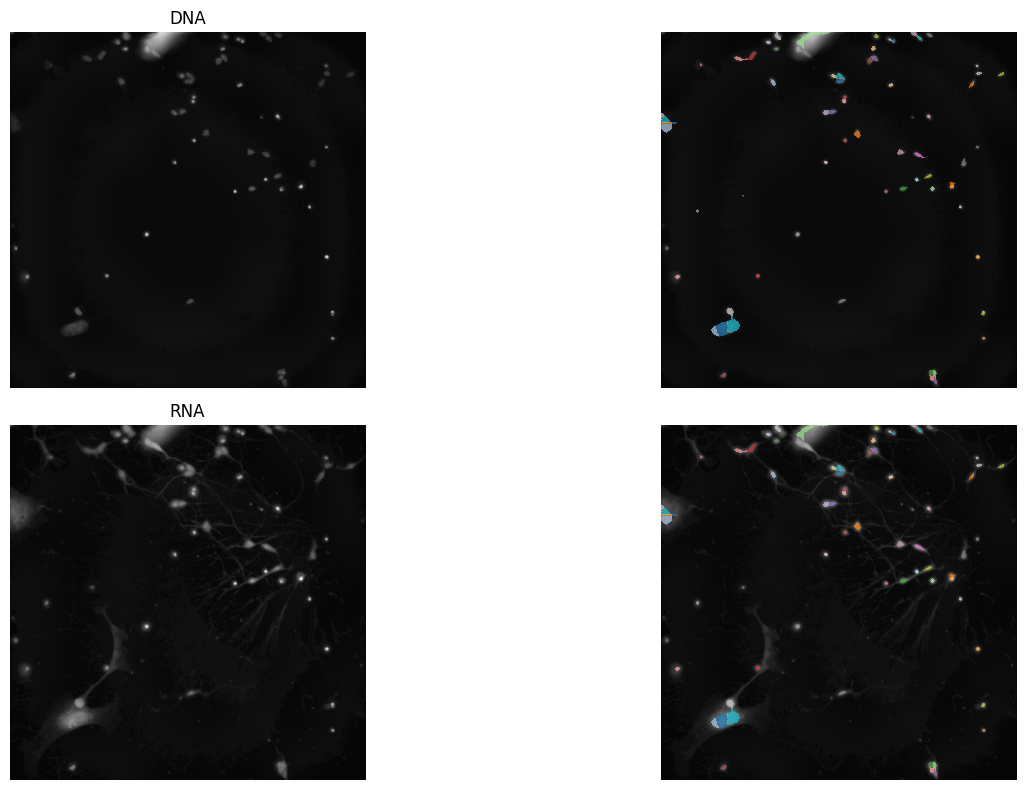

r01c01f02p01


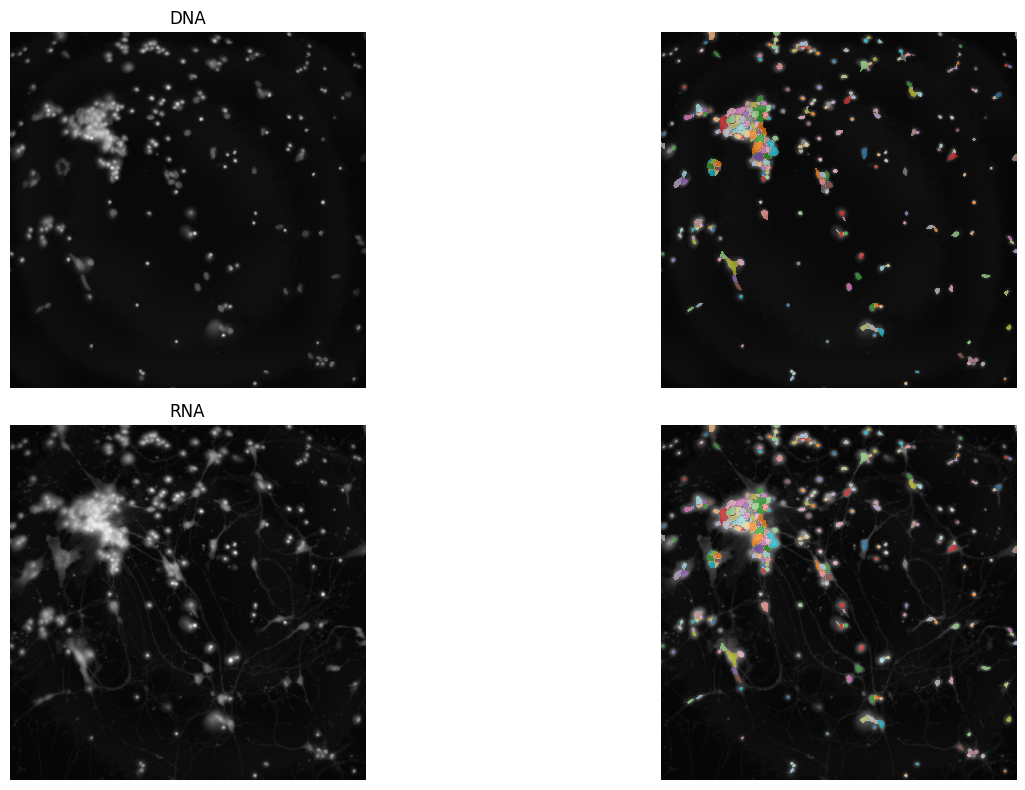

r01c01f03p01


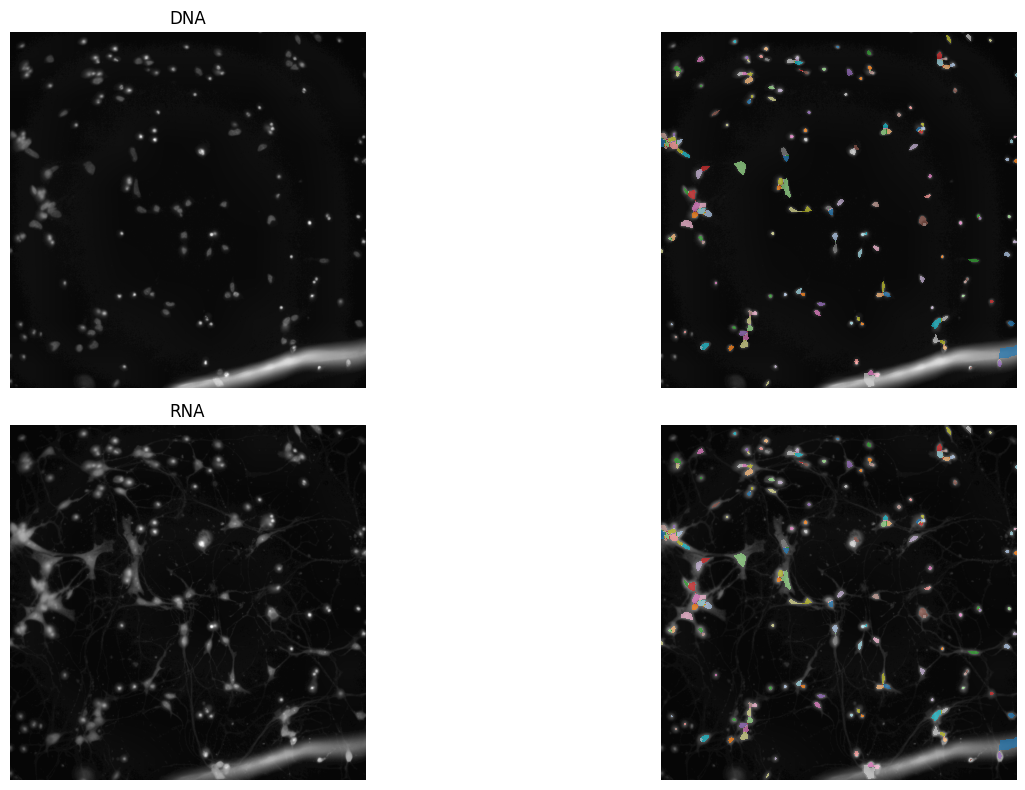

r01c01f04p01


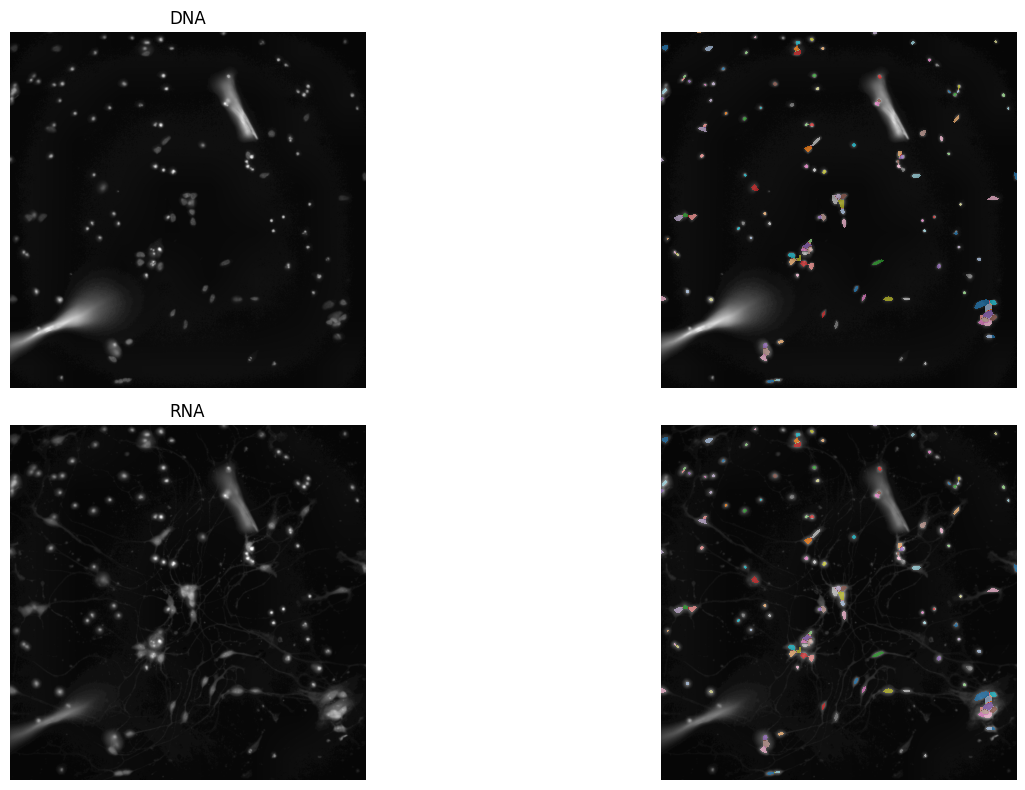

r01c01f05p01


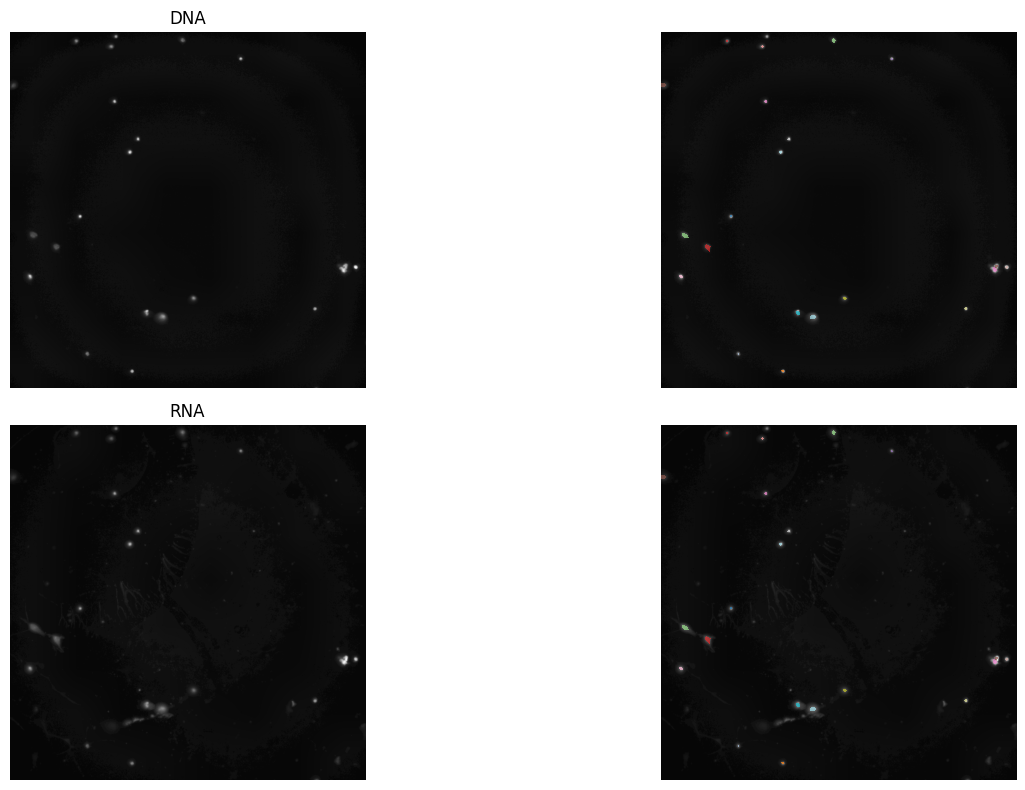

r01c01f06p01


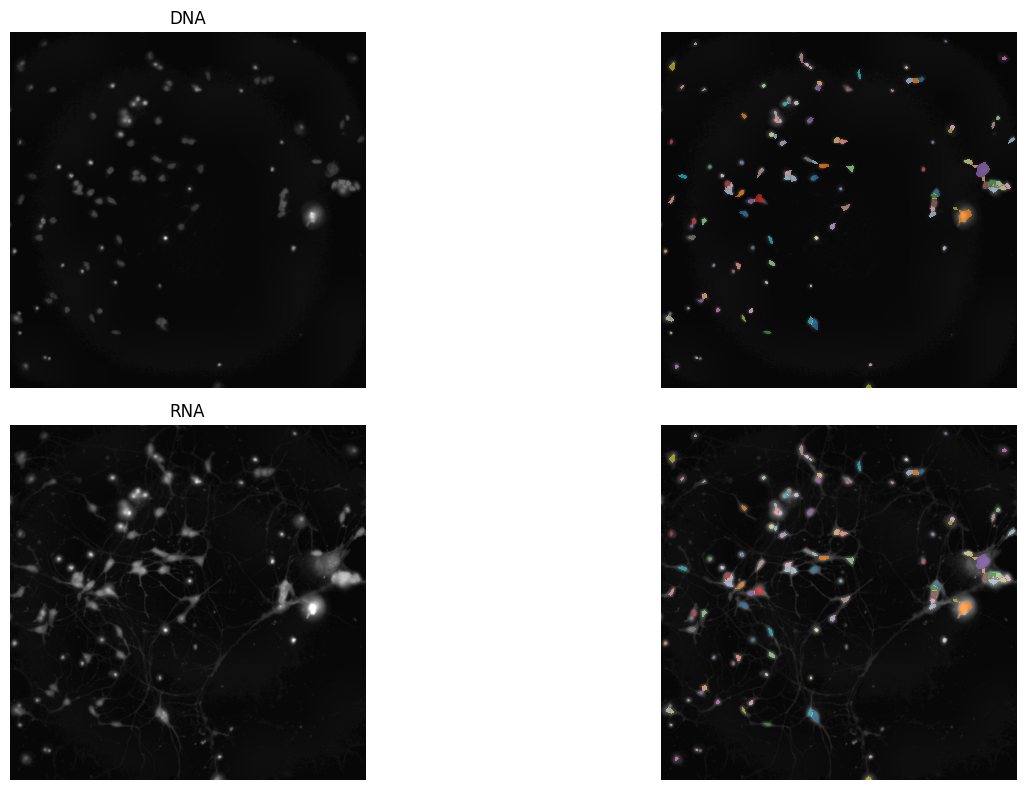

r01c01f07p01


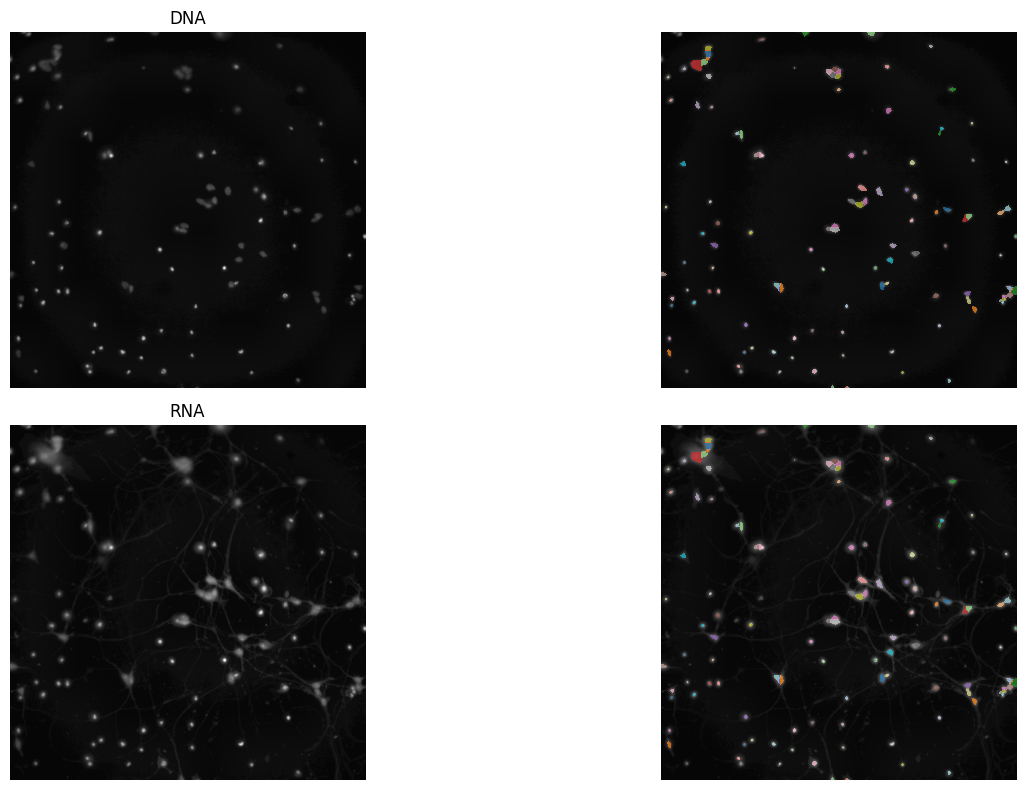

In [27]:
id_to_path_im = utils.get_id_to_path(path_dir_im)
id_to_path_seg_ilastik = utils.get_id_to_path(path_dir_seg_ilastik, tag_seg_ilastik)

for n_id, id in enumerate(id_to_path_seg_ilastik.keys()):
    print(id)
    images = utils.read_ims(id_to_path_im[id])

    seg_pred_ilastik = utils.read_seg(id_to_path_seg_ilastik[id])
    regions = utils.reg_prop_filter(measure.regionprops(seg_pred_ilastik), reg_stat_limits)
    seg_pred_ilastik_filtered = np.zeros_like(seg_pred_ilastik)
    for region in regions:
        seg_pred_ilastik_filtered[seg_pred_ilastik == region.label] = region.label

    image_dna = images[channels.index("DNA")]
    image_dna = exposure.equalize_adapthist(image_dna, clip_limit=0.03)
    image_rna = images[channels.index("RNA")]
    image_rna = exposure.equalize_adapthist(image_rna, clip_limit=0.03)

    f, axs = plt.subplots(nrows=2, ncols=2)
    for ax_col, seg in zip(axs.T, [np.zeros_like(image_dna), seg_pred_ilastik_filtered]):
        seg_masked = np.ma.masked_array(seg, mask=seg == 0)

        ax_col[0].imshow(image_dna, cmap="gray")
        ax_col[0].imshow(seg_masked % 20, cmap="tab20", alpha=0.7)
        ax_col[0].axis("off")

        ax_col[1].imshow(image_rna, cmap="gray")
        ax_col[1].imshow(seg_masked % 20, cmap="tab20", alpha=0.7)
        ax_col[1].axis("off")

    for ax_col, name in zip(axs, ["DNA", "CellProfiler", "ilastik", "CellPose"]):
        ax_col[0].set_title(name)

    axs[1,0].set_title("RNA")
    f.set_size_inches(16, 8)
    f.tight_layout()
    plt.show()

    if n_id > 5:
        break

In [24]:
from skimage import io

seg = io.imread("D:\Aneesh\Assay Dev 20230329\BR00142687__2024-03-29T18_18_57-Measurement 1\segmentations\\r01c01f01p01-ch7sk1fk1fl1.tif")